# Analyzing Geospatial Data (POI)
This tutorial extends some of the initial spatial analytics work we did in [previous tutorials](https://nbviewer.jupyter.org/github/carlobailey/urban-data-science/blob/gh-pages/tutorials/analyzing_geospatial_data.ipynb), by looking at more granular techniques to surface insights from geospatial data. Whereas in the previous tutorial looking at open spaces we aggregated information at the zipcode level, for this example we will be looking things in terms of coordinate points and distances. Specifically we will be utilizing NYC's property valuation data and POI (point of interest) data to study the relationship between a properties market value and its proximity to cultural institutions.

### Step 1: Download property valuation and building footprints

The three datasets we will need to download are:
- [NYC property valuation](https://data.cityofnewyork.us/City-Government/Property-Valuation-and-Assessment-Data/yjxr-fw8i)
- [NYC POI](https://data.cityofnewyork.us/City-Government/Points-Of-Interest/rxuy-2muj)
- [NYC building footprints](https://data.cityofnewyork.us/Housing-Development/Building-Footprints/nqwf-w8eh)

Depending on your connection, you can either download the data using the Socrata API or directly as a csv from the above links (the files are fairly large 2GB+)

In [1]:
import os
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")
import geopandas as gpd
import matplotlib.pyplot as plt
from sodapy import Socrata
import cenpy
from scipy.stats import pearsonr
from shapely import wkt
from shapely.geometry import shape
from shapely.ops import nearest_points

In [2]:
client = Socrata("data.cityofnewyork.us", os.environ['nyc_soda_cuny_token'])

In [ ]:
# Downloading property valuation through the Socrata API can take hours
# valuation = client.get("yjxr-fw8i", limit=10000000)

In [ ]:
# Downloading building footprints through the Socrata API can take hours
# bldgs = client.get("s75a-ei9u", limit=2000000)

In [3]:
# if downloading a csv update the next line with your path
valuation = pd.read_csv('data/Property_Valuation_and_Assessment_Data.csv',
                        dtype={'BORO': str, 'BLOCK': str, 'LOT': str})

In [4]:
valuation = valuation[valuation['YEAR'] == '2018/19']
valuation['bbl'] = valuation['BORO'] + valuation['BLOCK'] + valuation['LOT']

In [5]:
valuation = valuation.dropna(subset=['Latitude'])
print(valuation.shape)
valuation.head(2)

(1080953, 41)


,BBLE,BORO,BLOCK,LOT,EASEMENT,OWNER,BLDGCL,TAXCLASS,LTFRONT,LTDEPTH,...,Borough,Latitude,Longitude,Community Board,Council District,Census Tract,BIN,NTA,New Georeferenced Column,bbl
2615,1002007501,1,200,7501,NaN,OWNER / AGENT,R0,2,0,0,...,MANHATTAN,40.716989,-73.998297,103.0,1.0,29.0,1080816.0,Chinatown,POINT (-73.998297 40.716989),12007501
7560,1003967501,1,396,7501,NaN,NaN,R0,2,49,88,...,MANHATTAN,40.728875,-73.978428,103.0,2.0,28.0,1088495.0,Lower East Side,POINT (-73.978428 40.728875),13967501


In [6]:
valuation.rename(columns={'New Georeferenced Column': 'geom'}, inplace=True)
valuation['geom'] = valuation['geom'].apply(wkt.loads)

In [7]:
bldgs = pd.read_csv('data/building.csv', 
                    dtype={'BASE_BBL': str, 'MPLUTO_BBL': str})
bldgs['the_geom'] = bldgs['the_geom'].apply(wkt.loads)
print(bldgs.shape)
bldgs.head(2)

(1084926, 15)


,BIN,the_geom,NAME,LSTMODDATE,CNSTRCT_YR,LSTSTATYPE,DOITT_ID,HEIGHTROOF,FEAT_CODE,GROUNDELEV,SHAPE_AREA,SHAPE_LEN,BASE_BBL,MPLUTO_BBL,GEOMSOURCE
0,3394646,(POLYGON ((-73.87129515296562 40.6571737004345...,NaN,08/22/2017 12:00:00 AM +0000,2009.0,Constructed,1212853,21.608508,2100.0,18.0,854.662433,125.079796,3044520815,3044520815,Photogramm
1,4548330,(POLYGON ((-73.87670970144625 40.7142523454162...,NaN,08/17/2017 12:00:00 AM +0000,1930.0,Constructed,1226227,10.360000,5110.0,122.0,217.594243,60.225858,4030640041,4030640041,Photogramm


### Step 2: Merge valuation and building footprints data

Next we will assign a market value to buildings throughout the city by merging the property valuation and building footprints datasets. To do this will use the BBL code (Boro, Block, Lot), which is the city's way of identifying specific properties.

In [8]:
# convert data to GeoDataFrames
bldgs = gpd.GeoDataFrame(bldgs, geometry='the_geom')
valuation = gpd.GeoDataFrame(valuation, geometry='geom')
bldgs = bldgs.set_crs(epsg=3857)
valuation = valuation.set_crs(epsg=3857)

In [9]:
combined = bldgs.merge(valuation, left_on='MPLUTO_BBL',
                       right_on='BBLE')

In [10]:
classes = ['1', '2', '2A', '2B', '1D', '2C', '1B']
combined = combined[combined['TAXCLASS'].isin(classes)]

In [11]:
print(combined.shape)
combined.head(1)

(999945, 56)


,BIN_x,the_geom,NAME,LSTMODDATE,CNSTRCT_YR,LSTSTATYPE,DOITT_ID,HEIGHTROOF,FEAT_CODE,GROUNDELEV,...,Borough,Latitude,Longitude,Community Board,Council District,Census Tract,BIN_y,NTA,geom,bbl
0,3394646,"MULTIPOLYGON (((-73.87130 40.65717, -73.87136 ...",NaN,08/22/2017 12:00:00 AM +0000,2009.0,Constructed,1212853,21.608508,2100.0,18.0,...,BROOKLYN,40.657362,-73.8714,305.0,42.0,1070.0,3394646.0,East New York,POINT (-73.87140 40.65736),34452815


### Step 3: Download POI data

Seeing as though the POI dataset is fairly small (~20k rows), we can easily use the Socrata API to get the data. We then need to filter the data so that we are only left with cultural institutions.

In [31]:
poi = client.get("8mtx-gvr5", limit=25500)
poi_df = pd.DataFrame.from_records(poi)

In [32]:
poi_df['the_geom'] = poi_df['the_geom'].apply(lambda x: shape(x))

In [33]:
poi_df = gpd.GeoDataFrame(poi_df, geometry='the_geom')
poi_df = poi_df.set_crs(epsg=3857)

In [34]:
poi_df.shape

(20656, 16)

In [35]:
# filter data
places = ['museum', 'theatre', 'theater', 'gallery', 'thtr',
          'art', 'cinema', 'cinemas', 'moma', 'BREUER', 'drawing center']
culture_df = poi_df[(poi_df['facility_t']=='3') & 
                    (poi_df['name'].str.lower().str.contains('|'.join(places)))]

### Step 4: Create distance metrics

Next we need to calculate the distance to the nearest cultural institution from every property in NYC. The hypothesis here is that properties that are closer tend to have a higher market value. We will use the Shapely python library for the distance calculations.

In [17]:
# unary union of the culture_df geomtries 
clt = culture_df.the_geom.unary_union

def near(point, pts):
    # find the nearest poi
    nearest = nearest_points(point, pts)[1]
    return point.distance(nearest)

combined['distance'] = combined.apply(lambda x: near(x.the_geom.centroid, clt), axis=1)

### Step 5: Describe the data with simple statistics

Finally, now that we have all the data and it's in a format we want, we can begin describing it with simple statistics. For this example we will look at the differences between means – whether on average properties that are below the average distance to a cultural institution are higher in value. And we will also look at the correlation between property values and distances.

Note: we will save charts as PDF files so that you can further edit them in Illustrator or a similar program. You could do this in Python but it would be beyond the scope of this example.

In [26]:
closer = combined[combined['distance'] < combined['distance'].quantile(.25)]['FULLVAL'].mean()

In [27]:
further = combined[combined['distance'] > combined['distance'].quantile(.75)]['FULLVAL'].mean()

Text(0.5, 1.0, 'Property Value by Distance to Cultural Institution')

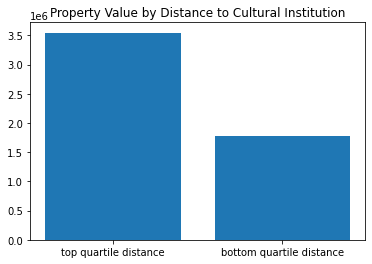

In [28]:
plt.bar(['top quartile distance', 'bottom quartile distance'], [closer, further])
plt.title('Property Value by Distance to Cultural Institution')
# Save to a PDF file
plt.savefig('prop_val_culture.pdf')

In [29]:
pearsonr(combined['distance'].loc[(combined['FULLVAL'] > 200000) & (combined['FULLVAL'] < 1000000)], 
         combined['FULLVAL'].loc[(combined['FULLVAL'] > 200000) & (combined['FULLVAL'] < 1000000)])

(-0.2942644131824561, 0.0)

<AxesSubplot:>

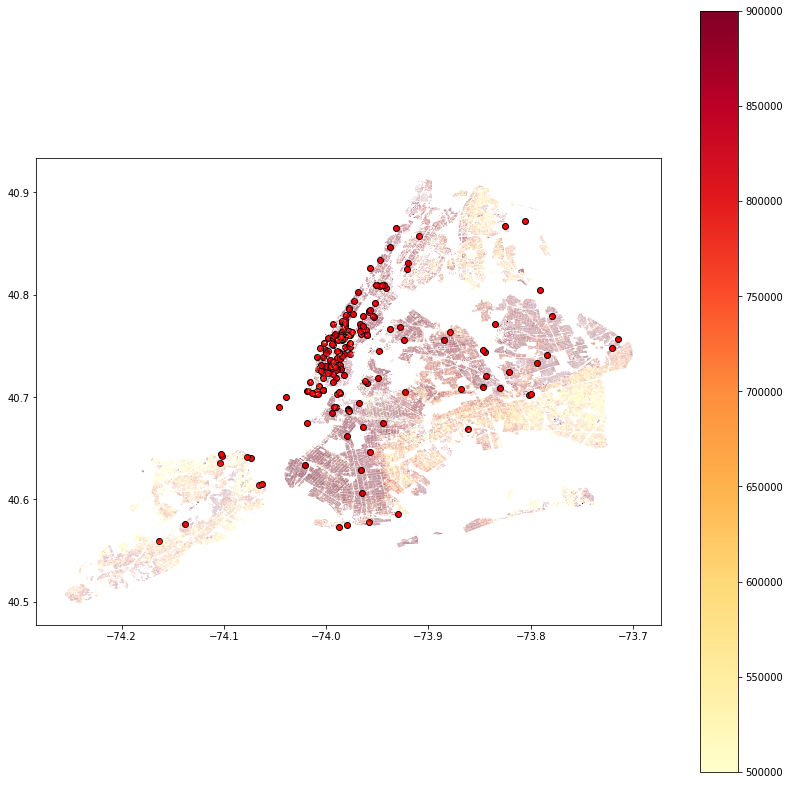

In [41]:
ax = culture_df.plot(color='red', edgecolor="black", figsize=(14, 14))
combined.plot(column='FULLVAL', ax=ax,
              vmin=500000, vmax=900000, cmap='Spectral',
              legend=True, figsize=(14, 14)) #.loc[combined['BORO'] == '1']